## Testing Two Versions of a Website's Call-to-Action Button (Version A vs. Version B)
#### Problem:
We want to know whether a new design for the website's call-to-action (CTA) button (Version B) increases the click-through rate (CTR) compared to the old design (Version A).

Version A (Control): Old button design.

Version B (Treatment): New button design.

We will perform Bayesian A/B testing on user clicks (binary outcome: clicked or not clicked).

In [21]:
### 1. Generating Synthetic Data (For the sake of example)
"""Let's assume we have observed the following data:

Control Group (Version A): 1000 users, with 150 clicks (CTR = 15%).

Treatment Group (Version B): 1000 users, with 180 clicks (CTR = 18%)."""

import pandas as pd
import numpy as np
!pip install pymc 
import pymc as pm
!pip install arviz
import arviz as az
import warnings
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
np.random.seed(42)

# Simulate Control Group (Version A) and Treatment Group (Version B) data
control_group = np.random.binomial(1, 0.15, size=1000)  # 15% CTR for Control
treatment_group = np.random.binomial(1, 0.18, size=1000)  # 18% CTR for Treatment

# Convert to pandas DataFrame for easier manipulation
data = pd.DataFrame({
    'version': ['A']*1000 + ['B']*1000,
    'click': np.concatenate([control_group, treatment_group])
})

# Check the first few rows
print(data.head())





[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  version  click
0       A      0
1       A      1
2       A      0
3       A      0
4       A      0



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
## 2. Bayesian Model Setup in PyMC

# Bayesian A/B Test Model
def run_bayesian_ab_test(control_data, treatment_data):
    with pm.Model() as model:
        # Priors for conversion rates (uniform prior)
        p_control = pm.Beta('p_control', alpha=1, beta=1)
        p_treatment = pm.Beta('p_treatment', alpha=1, beta=1)

        # Likelihood for control and treatment data
        control_obs = pm.Bernoulli('control_obs', p=p_control, observed=control_data)
        treatment_obs = pm.Bernoulli('treatment_obs', p=p_treatment, observed=treatment_data)

        # Sampling using NUTS (No U-Turn Sampler)
        trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2, init="adapt_diag", target_accept=0.9)

    return trace


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_control, p_treatment]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 78 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


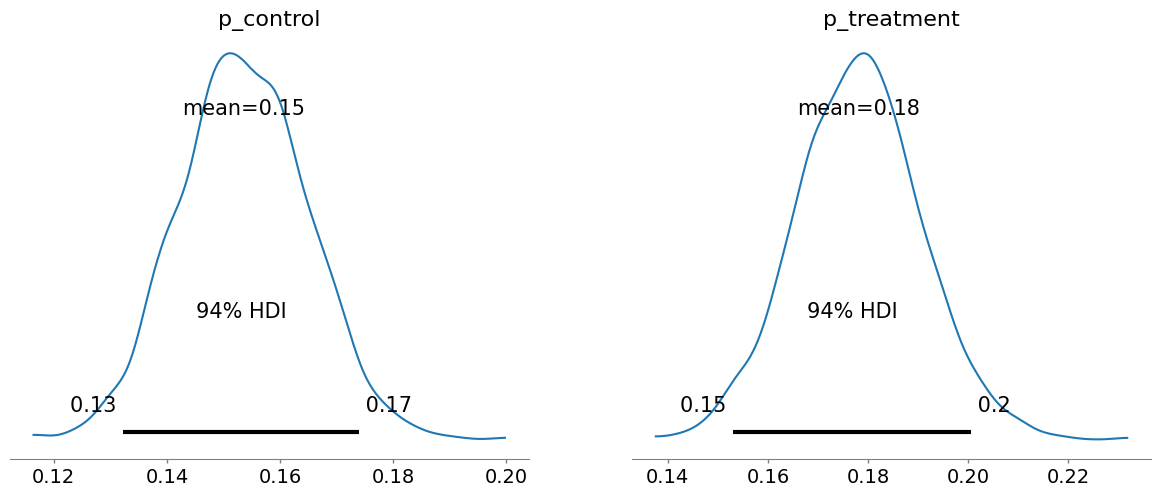

In [23]:
## 3. Running the Model and Plotting the Results
import matplotlib.pyplot as plt

# Extract control and treatment data
control_data = data[data['version'] == 'A']['click'].values
treatment_data = data[data['version'] == 'B']['click'].values

# Run the Bayesian A/B Test
trace = run_bayesian_ab_test(control_data, treatment_data)

# Plot the posterior distributions for control and treatment
az.plot_posterior(trace, var_names=['p_control', 'p_treatment'], hdi_prob=0.94)
plt.show()


In [24]:
# Flatten the posterior samples
p_control = trace.posterior['p_control'].values.flatten()
p_treatment = trace.posterior['p_treatment'].values.flatten()

# Calculate the probability that treatment > control
prob = (p_treatment > p_control).mean()

# Print the result
print(f"P(p_treatment > p_control) = {prob:.2f}")


P(p_treatment > p_control) = 0.94


## There is a 94% probability that the treatment group has a higher click-through rate (CTR) than the control group, given the observed data and the prior assumptions.